In [3]:
import os
from glob import glob
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import gridspec
import seaborn as sns
import json
import torch
import gpytorch
import h5py
import collections
import scipy
import torch

from bnn_priors import prior

from bnn_priors.exp_utils import load_samples

%matplotlib inline

# Explore weights of the MNIST network, that doesn't have batchnorm

In [2]:
directories = [*map(str, range(0, 8))]
samples = collections.defaultdict(lambda: [], {})
param_keys = None

for d in directories:
    with h5py.File(f"../logs/0_3_cifar10_sgd/{d}/samples.pt", "r", swmr=True) as f:
        if param_keys is None:
            param_keys = [k for k in f.keys() if k.endswith(".p")]
            
        for key in param_keys:
            samples[ke(y].append(f[key][-1])
            print(lenf[key]))

50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
66
66
66
66
66
66
66
66
66
66
66
66
66
66
66
66
66
66
66
66
66
66
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
74
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67


In [4]:
for k in samples.keys():
    samples[k] = np.stack(samples[k])
samples = dict(samples)

In [5]:
samples.keys()

dict_keys(['net.module.conv1.weight_prior.p', 'net.module.layer1.0.conv1.weight_prior.p', 'net.module.layer1.0.conv2.weight_prior.p', 'net.module.layer1.1.conv1.weight_prior.p', 'net.module.layer1.1.conv2.weight_prior.p', 'net.module.layer2.0.conv1.weight_prior.p', 'net.module.layer2.0.conv2.weight_prior.p', 'net.module.layer2.0.shortcut.0.weight_prior.p', 'net.module.layer2.1.conv1.weight_prior.p', 'net.module.layer2.1.conv2.weight_prior.p', 'net.module.layer3.0.conv1.weight_prior.p', 'net.module.layer3.0.conv2.weight_prior.p', 'net.module.layer3.0.shortcut.0.weight_prior.p', 'net.module.layer3.1.conv1.weight_prior.p', 'net.module.layer3.1.conv2.weight_prior.p', 'net.module.layer4.0.conv1.weight_prior.p', 'net.module.layer4.0.conv2.weight_prior.p', 'net.module.layer4.0.shortcut.0.weight_prior.p', 'net.module.layer4.1.conv1.weight_prior.p', 'net.module.layer4.1.conv2.weight_prior.p', 'net.module.linear.bias_prior.p', 'net.module.linear.weight_prior.p'])

In [10]:
samples_reshaped = {}
mean_covs = {}

for k in samples.keys():
    if "weight_prior" in k and k != 'net.module.linear.weight_prior.p' and "shortcut" not in k:
        #if k == "net.module.8.weight_prior.p":
        #    samples_reshaped[k] = samples[k].transpose((0, 2, 1)).reshape((-1, 10))
        #else:
        samples_reshaped[k] = samples[k].reshape((-1, samples[k].shape[-2]*samples[k].shape[-1]))
        mean_covs[k] = (np.mean(samples_reshaped[k], 0), np.cov(samples_reshaped[k], rowvar=False))
    else:
        samples_reshaped[k] = samples[k]    
        mean_covs[k] = (np.mean(samples[k]), np.var(samples[k]))

In [7]:
[k for k in samples.keys() if "shortcut" in k]

['net.module.layer2.0.shortcut.0.weight_prior.p',
 'net.module.layer3.0.shortcut.0.weight_prior.p',
 'net.module.layer4.0.shortcut.0.weight_prior.p']

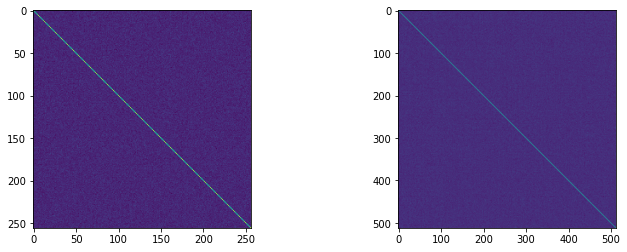

In [25]:
a = samples['net.module.layer4.0.shortcut.0.weight_prior.p']

_, axes = plt.subplots(1, 2, figsize=(12, 4))
cov = np.cov(a.reshape((7*512, 256)), rowvar=False)
axes[0].imshow((np.diag(cov)[:, None]*np.diag(cov))**-.5 * cov)
cov = np.cov(a.transpose((1, 0, 2, 3, 4)).reshape((512, 7*256)), rowvar=True)
axes[1].imshow((np.diag(cov)[:, None]*np.diag(cov))**-.5 * cov)

In [66]:
samples['net.module.linear.weight_prior.p'].shape

(8, 10, 512)

In [27]:
pd.to_pickle(mean_covs, "../bnn_priors/models/cifar10_mean_covs.pkl.gz")

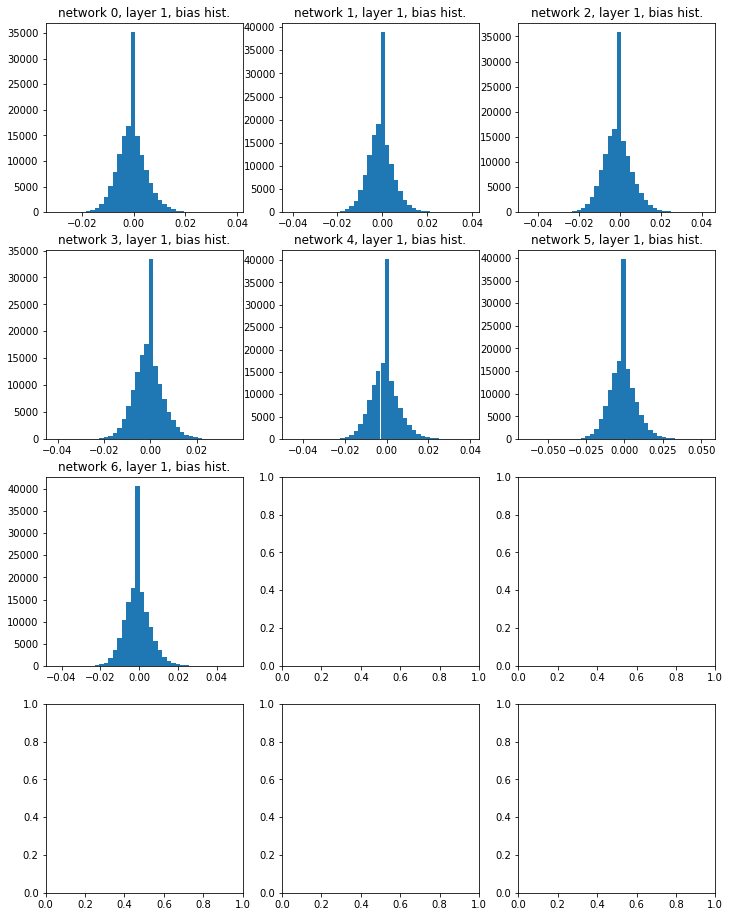

In [29]:
_, axes = plt.subplots(4, 3, figsize=(12, 16))
for i, s in enumerate(samples['net.module.layer2.0.conv2.weight_prior.p'].reshape((7, -1))):
    axes.flat[i].hist(s, bins=40)
    axes.flat[i].set_title(f"network {i}, layer 1, bias hist.")

Text(0.5, 1.0, 'Final layer bias hist.')

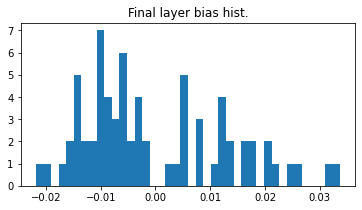

In [31]:
_, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.hist(samples['net.module.linear.bias_prior.p'].flat, bins=40)
ax.set_title("Final layer bias hist.")

Text(0.5, 1.0, 'Final layer bias hist.')

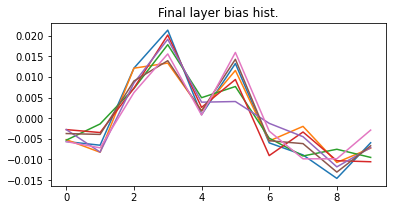

In [8]:
_, ax = plt.subplots(1, 1, figsize=(6, 3))
for i in range(7):
    ax.plot(samples['net.module.linear.bias_prior.p'][i])
ax.set_title("Final layer bias hist.")

In [9]:
sum(len(var.shape) == 2 for k, (_, var) in mean_covs.items())

17

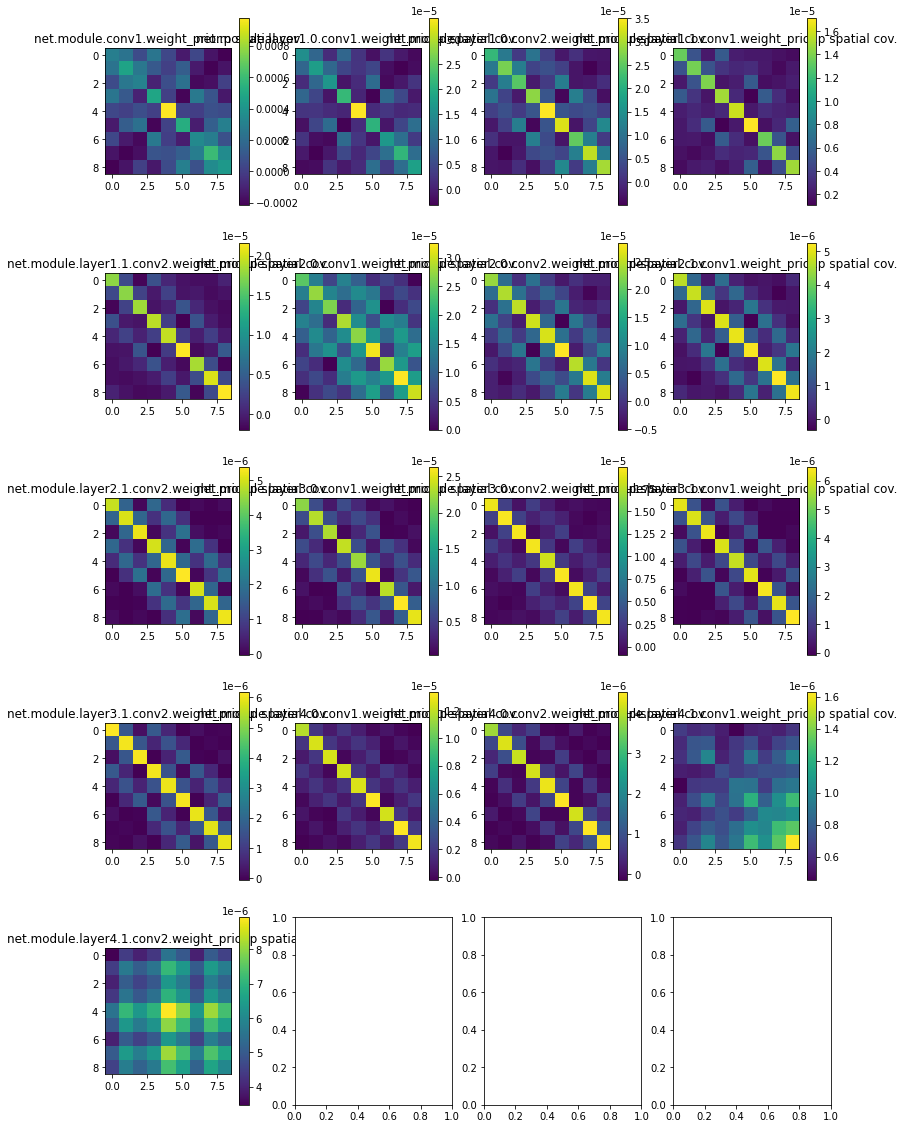

In [11]:
fig, axes = plt.subplots(5, 4, figsize=(13, 20))

i = 0
for key, (_, cov) in mean_covs.items():
    if len(cov.shape) != 2:
        continue
    ax = axes.flat[i]
    i += 1
    
    mappable = ax.imshow(mean_covs[key][1], cmap=plt.get_cmap('viridis'))
    fig.colorbar(mappable, ax=ax)
    ax.set_title(f"{key} spatial cov.")


In [50]:
np.random.permutation(len(a))

array([ 303021,  293352, 1676294, ..., 1284530, 1348341,  140758])

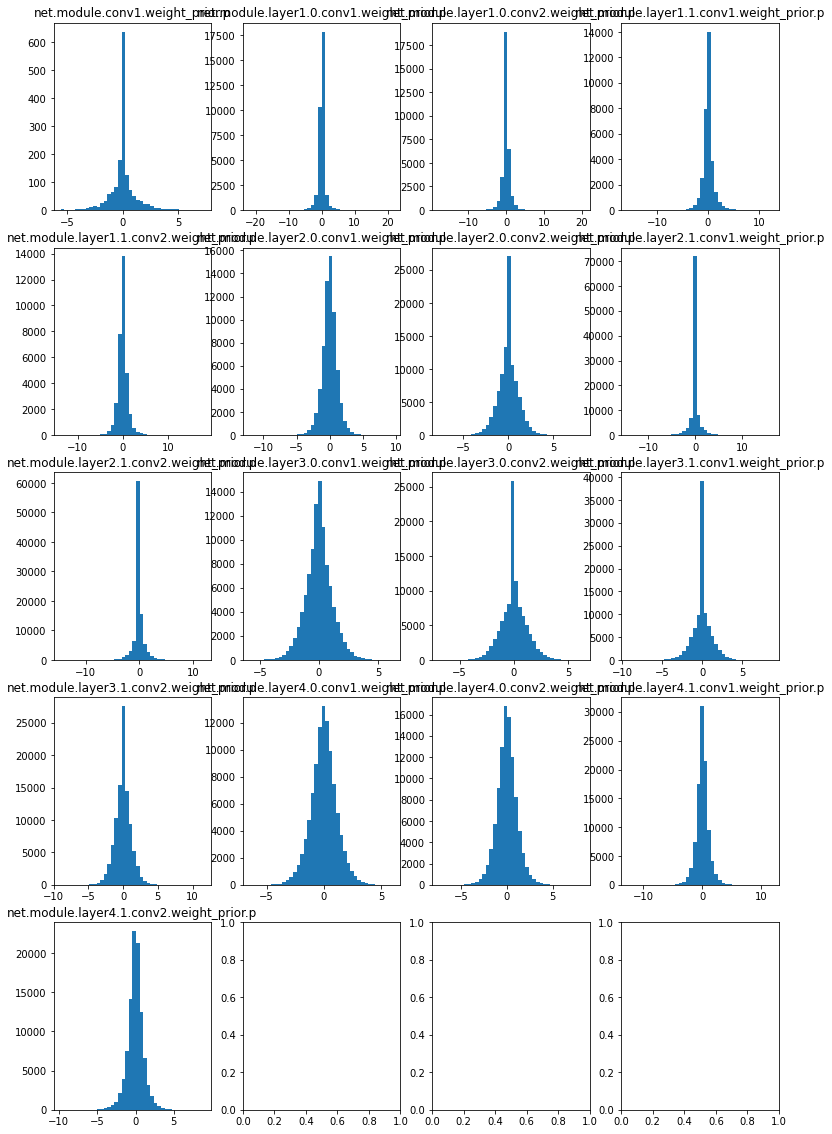

In [132]:
fig, axes = plt.subplots(5, 4, figsize=(13, 20))

whites = {}

i = 0
for key, (_, cov) in mean_covs.items():
    if len(cov.shape) != 2:
        continue
    ax = axes.flat[i]
    i += 1
    
    a = samples_reshaped[key] - mean_covs[key][0]
    vals, vecs = np.linalg.eig(mean_covs[key][1])
    whites[key] = a_white = a @ (vecs * vals**-.5)
    perm = np.random.permutation(len(a_white))
    heights, bins, _ = ax.hist(a_white.ravel()[perm[:100000]], bins=40)
    area = (bins[1:] - bins[:-1]) @ heights
    
    
    ax.set_title(key)

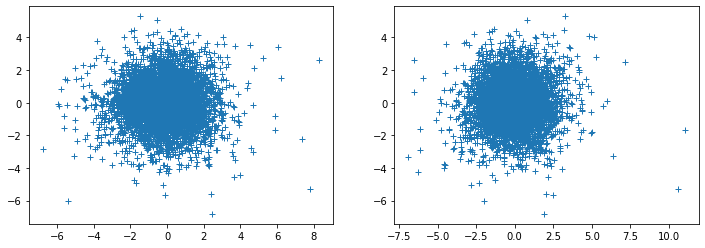

In [65]:
_, axes = plt.subplots(1, 2, figsize=(12, 4))

key = 'net.module.layer2.1.conv2.weight_prior.p'
axes[0].plot(whites[key][:len(whites[key])//7, 0],
             whites[key][:len(whites[key])//7, 8], ls='none', marker='+')
axes[1].plot(whites[key][:len(whites[key])//7, 7],
             whites[key][:len(whites[key])//7, 8], ls='none', marker='+')

Text(0.5, 1.0, 'Lay. 2 whitened weights')

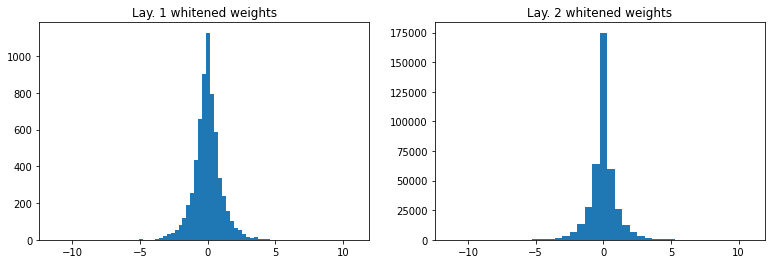

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4), sharex=True)

prior_whites = {}

ax = axes[0]
key = "net.module.1.weight_prior.p"
a = prior_samples_reshaped[key] - prior_mean_covs[key][0]
vals, vecs = np.linalg.eig(prior_mean_covs[key][1])
prior_whites[key] = a_white = a @ (vecs * vals**-.5)
ax.hist(a_white.flat, bins=40)
ax.set_title("Lay. 1 whitened weights")

ax = axes[1]
key = "net.module.4.weight_prior.p"
a = prior_samples_reshaped[key] - prior_mean_covs[key][0]
vals, vecs = np.linalg.eig(prior_mean_covs[key][1])
prior_whites[key] = a_white = a @ (vecs * vals**-.5)
ax.hist(a_white.flat, bins=40)
ax.set_title("Lay. 2 whitened weights")

Text(0.5, 1.0, 'Lay. 3 filter-wise cov.')

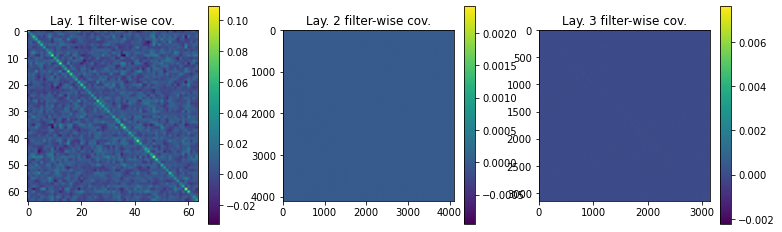

In [137]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4))
covs_big = {}

ax = axes[0]
key = "net.module.1.weight_prior.p"
a = samples[key].transpose((0, 2, 3, 4, 1)).reshape((99, -1))
covs_big[key] = a.T @ a / len(a)
mappable = ax.imshow(covs_big[key], cmap=plt.get_cmap('viridis'))
fig.colorbar(mappable, ax=ax)
ax.set_title("Lay. 1 filter-wise cov.")


ax = axes[1]
key = "net.module.4.weight_prior.p"
a = samples[key].transpose((0, 2, 3, 4, 1)).reshape((99, -1))
covs_big[key] = a.T @ a / len(a)
mappable = ax.imshow(covs_big[key], cmap=plt.get_cmap('viridis'))
fig.colorbar(mappable, ax=ax)
ax.set_title("Lay. 2 filter-wise cov.")

ax = axes[2]
key = "net.module.8.weight_prior.p"
a = samples[key].reshape((11*10, -1))
covs_big[key] = a.T @ a / len(a)
mappable = ax.imshow(covs_big[key], cmap=plt.get_cmap('viridis'))
fig.colorbar(mappable, ax=ax)
ax.set_title("Lay. 3 filter-wise cov.")

Text(0.5, 1.0, 'Layer 2 filter-wise cov')

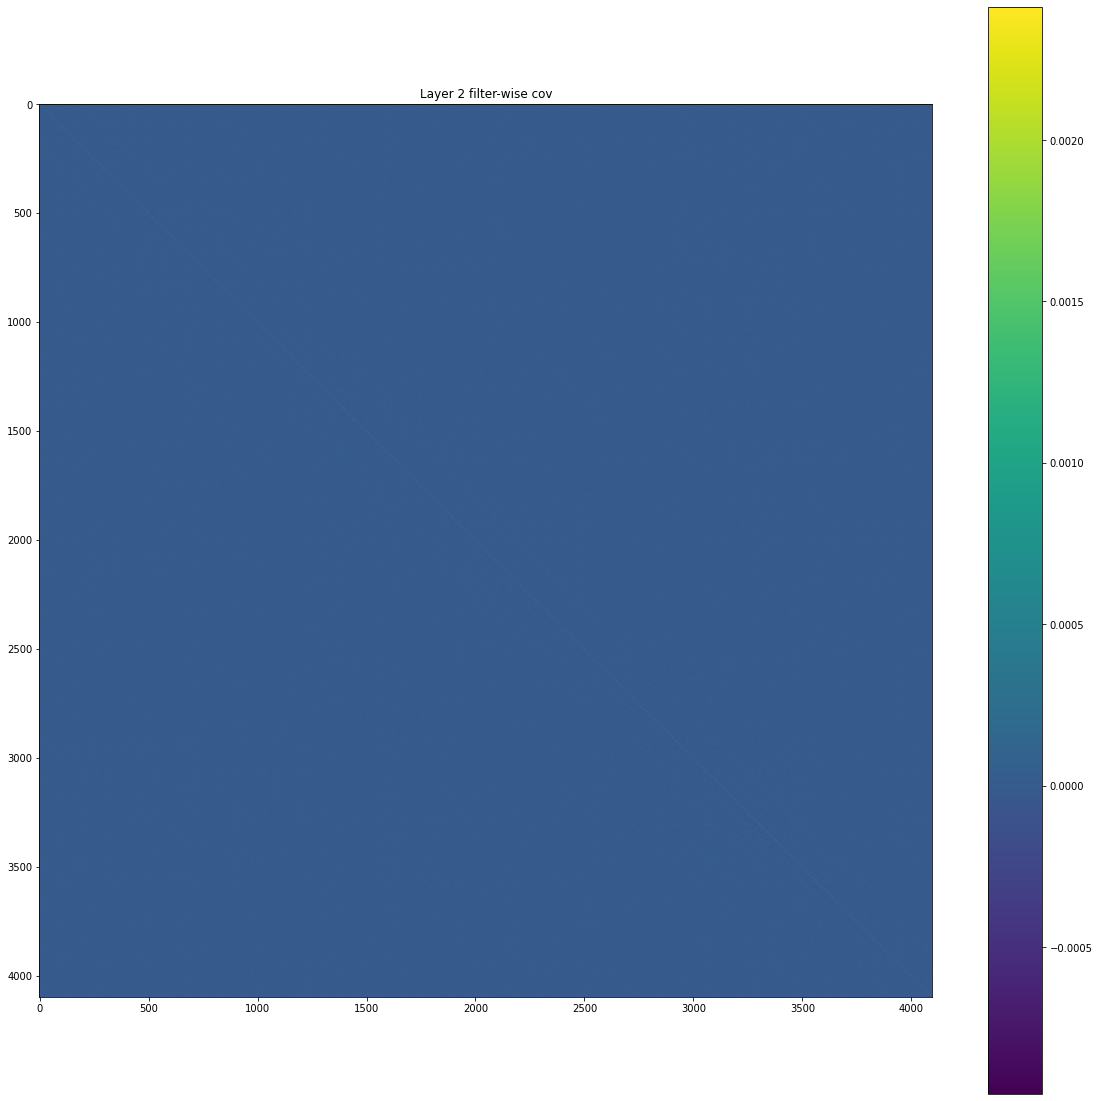

In [141]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

key = "net.module.4.weight_prior.p"
a = samples[key].transpose((0, 2, 3, 4, 1)).reshape((99, -1))
covs[key] = a.T @ a / len(a)
mappable = ax.imshow(covs[key], cmap=plt.get_cmap('viridis'))
fig.colorbar(mappable, ax=ax)
plt.title("Layer 2 filter-wise cov")

# Fit any scipy.stats distribution to the biases

In [76]:
from scipy.stats import rv_continuous

def fit_1d_dist(data, whitelist=None):
    fits = []
    data = data.ravel()
    if whitelist is None:
        whitelist = dir(scipy.stats)
    for attr in whitelist:
        try:
            dist_class = getattr(scipy.stats, attr)
            if isinstance(dist_class, rv_continuous) and attr != "levy_stable":
                args = dist_class.fit(data)
                likelihood = dist_class.logpdf(data, *args).sum()
                fits.append((attr, likelihood, args))
                print(attr, likelihood)
        except Exception as e:
            print(f"{attr} raised exception {e}")
            
    fits.sort(key=lambda x: -x[1])
    fits_dict = dict((name, args) for (name, _, args) in fits)
    return fits, fits_dict

In [42]:
def plot_top_fits(data, fits, title, idx, ax=None, bins=40):
    data = data.ravel()
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10, 8))
    heights, bins, _ = ax.hist(data, bins=bins)
    area = (bins[1:] - bins[:-1]) @ heights

    x = np.linspace(data.min(), data.max(), 5000)

    for attr, _, args in fits[idx]:
        y = getattr(scipy.stats, attr).pdf(x, *args) * area
        ax.plot(x, y, label=attr)
    ax.set_title(title)
    ax.legend()

In [16]:
fits = {}
fits_dict = {}

In [18]:
for key, value in whites.items():
    fits[key], fits_dict[key] = fit_1d_dist(value, whitelist=["dgamma", "laplace", "gennorm", "t", "cauchy"])
    print(key, [f[0] for f in fits[key][:3]])

net.module.conv1.weight_prior.p ['gennorm', 'dgamma', 't']
net.module.layer1.0.conv1.weight_prior.p ['gennorm', 'dgamma', 't']
net.module.layer1.0.conv2.weight_prior.p ['gennorm', 'dgamma', 't']
net.module.layer1.1.conv1.weight_prior.p ['dgamma', 'gennorm', 't']
net.module.layer1.1.conv2.weight_prior.p ['gennorm', 'dgamma', 'laplace']
net.module.layer2.0.conv1.weight_prior.p ['gennorm', 'dgamma', 't']
net.module.layer2.0.conv2.weight_prior.p ['dgamma', 'laplace', 'gennorm']
net.module.layer2.1.conv1.weight_prior.p ['gennorm', 'dgamma', 't']
net.module.layer2.1.conv2.weight_prior.p ['gennorm', 'dgamma', 't']
net.module.layer3.0.conv1.weight_prior.p ['gennorm', 't', 'dgamma']
net.module.layer3.0.conv2.weight_prior.p ['dgamma', 'gennorm', 'laplace']
net.module.layer3.1.conv1.weight_prior.p ['dgamma', 'gennorm', 'laplace']
net.module.layer3.1.conv2.weight_prior.p ['dgamma', 'gennorm', 'laplace']
net.module.layer4.0.conv1.weight_prior.p ['gennorm', 't', 'dgamma']
net.module.layer4.0.conv2.w

In [119]:
pd.to_pickle((fits, fits_dict), "cifar10_weight_fits.pkl.gz")

In [128]:
fits['net.module.linear.weight_prior.p']

[('gennorm',
  62799.642179960625,
  (2.118945376700686, -4.026936190674179e-09, 0.07600564140484657))]

gennorm 62799.642179960625


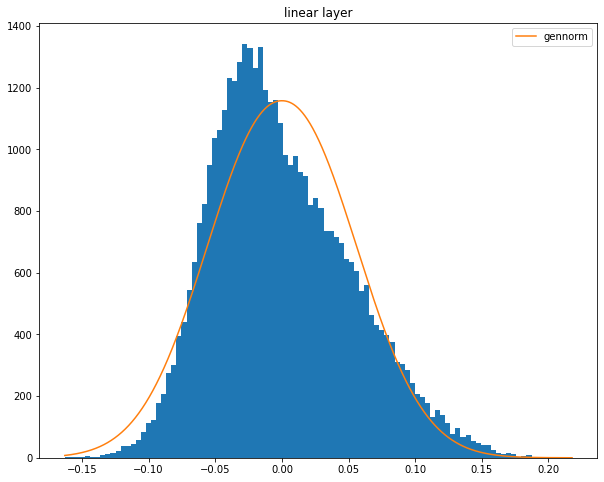

In [121]:
key = 'net.module.linear.weight_prior.p'
fits[key], fits_dict[key] = fit_1d_dist(samples[key], whitelist=["gennorm"])
plot_top_fits(samples[key], fits[key], "linear layer", slice(0, 1), bins=100)

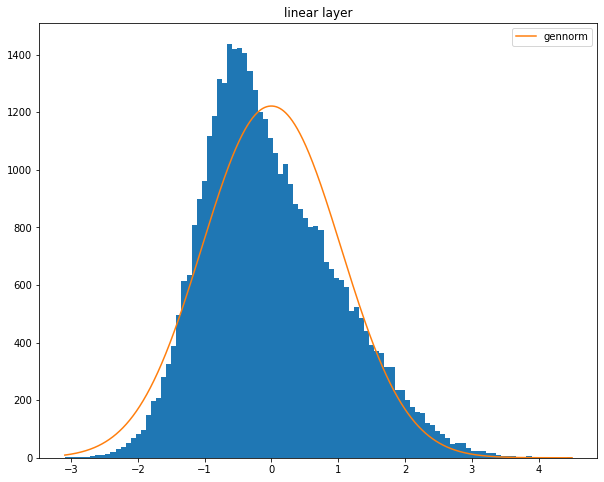

In [110]:
plot_top_fits(reshaped.ravel(), [("gennorm", None, fd["gennorm"])], "linear layer", slice(0, 30), bins=100)

In [101]:
[a for a in f if a[0] == "t"], f[1]

([('t',
   -58116.910817460695,
   (107.3303849015267, -0.004919001112122469, 0.990650149639867))],
 ('skewnorm',
  -56805.29764329584,
  (2.782306544588116, -1.1418681942345525, 1.5177114608323645)))

In [23]:
df = pd.DataFrame({k: {dist_name: lik for (dist_name, lik, _) in v} for (k, v) in fits.items()})
df

,net.module.conv1.weight_prior.p,net.module.layer1.0.conv1.weight_prior.p,net.module.layer1.0.conv2.weight_prior.p,net.module.layer1.1.conv1.weight_prior.p,net.module.layer1.1.conv2.weight_prior.p,net.module.layer2.0.conv1.weight_prior.p,net.module.layer2.0.conv2.weight_prior.p,net.module.layer2.1.conv1.weight_prior.p,net.module.layer2.1.conv2.weight_prior.p,net.module.layer3.0.conv1.weight_prior.p,net.module.layer3.0.conv2.weight_prior.p,net.module.layer3.1.conv1.weight_prior.p,net.module.layer3.1.conv2.weight_prior.p,net.module.layer4.0.conv1.weight_prior.p,net.module.layer4.0.conv2.weight_prior.p,net.module.layer4.1.conv1.weight_prior.p,net.module.layer4.1.conv2.weight_prior.p
gennorm,-12798.282761,-137167.088870,-318077.583103,-332482.666504,-367729.726039,-809787.306517,-1.611094e+06,-6.288725e+05,-7.398632e+05,-3.302901e+06,-5.969158e+06,-4.996101e+06,-6.375281e+06,-1.321548e+07,-2.639438e+07,-2.532601e+07,-2.542020e+07
dgamma,-13238.062972,-142265.672831,-323260.161358,-329270.286740,-367863.276983,-810232.918217,-1.602999e+06,-6.923732e+05,-7.529550e+05,-3.315856e+06,-5.594129e+06,-4.827424e+06,-6.290900e+06,-1.325416e+07,-2.648262e+07,-2.531564e+07,-2.540054e+07
t,-14076.286708,-175775.672953,-325527.653800,-346857.922815,-370857.797150,-810493.269142,-1.637777e+06,-7.182987e+05,-9.231996e+05,-3.311228e+06,-6.498852e+06,-5.840502e+06,-6.505597e+06,-1.324475e+07,-2.640522e+07,-2.533696e+07,-2.541277e+07
cauchy,-14317.647020,-186959.336299,-331092.596433,-354003.191450,-386874.503447,-871105.736326,-1.736398e+06,-8.007469e+05,-1.059790e+06,-3.598519e+06,-6.689333e+06,-5.853824e+06,-6.860940e+06,-1.439462e+07,-2.876360e+07,-2.693131e+07,-2.705992e+07
laplace,-15385.136289,-255803.486706,-333493.297365,-348592.181052,-370498.342039,-811680.833022,-1.610863e+06,-1.157309e+06,-1.254001e+06,-3.328385e+06,-6.234413e+06,-5.766811e+06,-6.382645e+06,-1.332587e+07,-2.661895e+07,-2.532869e+07,-2.542886e+07


In [46]:
df_params = pd.DataFrame({k: {"beta": v["gennorm"][0], "loc": v["gennorm"][1], "scale": v["gennorm"][2]} for k, v in fits_dict.items()})
df_params

,net.module.conv1.weight_prior.p,net.module.layer1.0.conv1.weight_prior.p,net.module.layer1.0.conv2.weight_prior.p,net.module.layer1.1.conv1.weight_prior.p,net.module.layer1.1.conv2.weight_prior.p,net.module.layer2.0.conv1.weight_prior.p,net.module.layer2.0.conv2.weight_prior.p,net.module.layer2.1.conv1.weight_prior.p,net.module.layer2.1.conv2.weight_prior.p,net.module.layer3.0.conv1.weight_prior.p,net.module.layer3.0.conv2.weight_prior.p,net.module.layer3.1.conv1.weight_prior.p,net.module.layer3.1.conv2.weight_prior.p,net.module.layer4.0.conv1.weight_prior.p,net.module.layer4.0.conv2.weight_prior.p,net.module.layer4.1.conv1.weight_prior.p,net.module.layer4.1.conv2.weight_prior.p
beta,3.714105e-01,2.531219e-01,5.984252e-01,5.525030e-01,7.893836e-01,1.162643e+00,9.674905e-01,2.496104e-01,2.248289e-01,1.349511e+00,0.410428,3.322134e-01,0.881632,1.360580e+00,1.356167e+00,1.031530,1.055218
loc,2.827888e-08,-7.688927e-08,2.934233e-08,1.571357e-07,4.530257e-09,1.569220e-07,-4.818411e-09,4.302196e-07,-4.838427e-07,1.110956e-07,-0.001939,-4.670887e-07,-0.000002,-1.553486e-07,4.332357e-07,0.000001,0.005125
scale,2.066923e-02,6.873329e-04,1.831300e-01,1.494504e-01,4.284401e-01,8.801430e-01,6.868928e-01,6.401946e-04,2.276269e-04,1.053795e+00,0.049979,1.169123e-02,0.583488,1.062122e+00,1.056931e+00,0.734813,0.761263


In [27]:
(df - df.max(0)) / df.max(0).abs()

,net.module.conv1.weight_prior.p,net.module.layer1.0.conv1.weight_prior.p,net.module.layer1.0.conv2.weight_prior.p,net.module.layer1.1.conv1.weight_prior.p,net.module.layer1.1.conv2.weight_prior.p,net.module.layer2.0.conv1.weight_prior.p,net.module.layer2.0.conv2.weight_prior.p,net.module.layer2.1.conv1.weight_prior.p,net.module.layer2.1.conv2.weight_prior.p,net.module.layer3.0.conv1.weight_prior.p,net.module.layer3.0.conv2.weight_prior.p,net.module.layer3.1.conv1.weight_prior.p,net.module.layer3.1.conv2.weight_prior.p,net.module.layer4.0.conv1.weight_prior.p,net.module.layer4.0.conv2.weight_prior.p,net.module.layer4.1.conv1.weight_prior.p,net.module.layer4.1.conv2.weight_prior.p
gennorm,0.000000,0.000000,0.000000,-0.009756,0.000000,0.000000,-0.005049,0.000000,0.000000,0.000000,-0.067040,-0.034941,-0.013413,0.000000,0.000000,-0.000409,-0.000774
dgamma,-0.034362,-0.037171,-0.016293,0.000000,-0.000363,-0.000550,0.000000,-0.100975,-0.017695,-0.003922,0.000000,0.000000,0.000000,-0.002927,-0.003343,0.000000,0.000000
t,-0.099857,-0.281471,-0.023422,-0.053414,-0.008506,-0.000872,-0.021695,-0.142201,-0.247798,-0.002521,-0.161727,-0.209859,-0.034128,-0.002214,-0.000410,-0.000842,-0.000481
cauchy,-0.118716,-0.363004,-0.040918,-0.075114,-0.052062,-0.075722,-0.083218,-0.273306,-0.432413,-0.089503,-0.195777,-0.212619,-0.090614,-0.089224,-0.089762,-0.063821,-0.065328
laplace,-0.202125,-0.864904,-0.048465,-0.058681,-0.007529,-0.002338,-0.004906,-0.840292,-0.694910,-0.007716,-0.114456,-0.194594,-0.014584,-0.008353,-0.008508,-0.000515,-0.001115


(array([1.00000e+00, 0.00000e+00, 2.00000e+00, 1.00000e+00, 1.00000e+01,
        1.40000e+01, 3.60000e+01, 8.10000e+01, 1.70000e+02, 4.25000e+02,
        8.00000e+02, 1.52700e+03, 2.99000e+03, 5.41000e+03, 9.27600e+03,
        1.49060e+04, 2.29350e+04, 3.14680e+04, 4.07590e+04, 5.07180e+04,
        1.77418e+05, 4.79290e+04, 3.80180e+04, 2.86790e+04, 1.99270e+04,
        1.31650e+04, 7.82600e+03, 4.58300e+03, 2.54300e+03, 1.32900e+03,
        7.02000e+02, 3.39000e+02, 1.55000e+02, 8.10000e+01, 2.70000e+01,
        1.30000e+01, 1.70000e+01, 3.00000e+00, 3.00000e+00, 2.00000e+00]),
 array([-7.08344415, -6.73582794, -6.38821174, -6.04059553, -5.69297933,
        -5.34536312, -4.99774691, -4.65013071, -4.3025145 , -3.9548983 ,
        -3.60728209, -3.25966588, -2.91204968, -2.56443347, -2.21681727,
        -1.86920106, -1.52158485, -1.17396865, -0.82635244, -0.47873624,
        -0.13112003,  0.21649618,  0.56411238,  0.91172859,  1.25934479,
         1.606961  ,  1.95457721,  2.30219341,  2

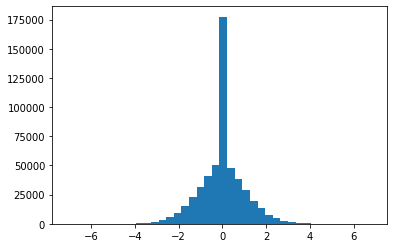

In [134]:
plt.hist(whites["net.module.layer3.0.conv2.weight_prior.p"][:, 4], bins=40)

In [150]:
mats = samples["net.module.layer3.0.conv2.weight_prior.p"][...].reshape((8, 256, 256*3*3))



(8, 256, 256, 3, 3)

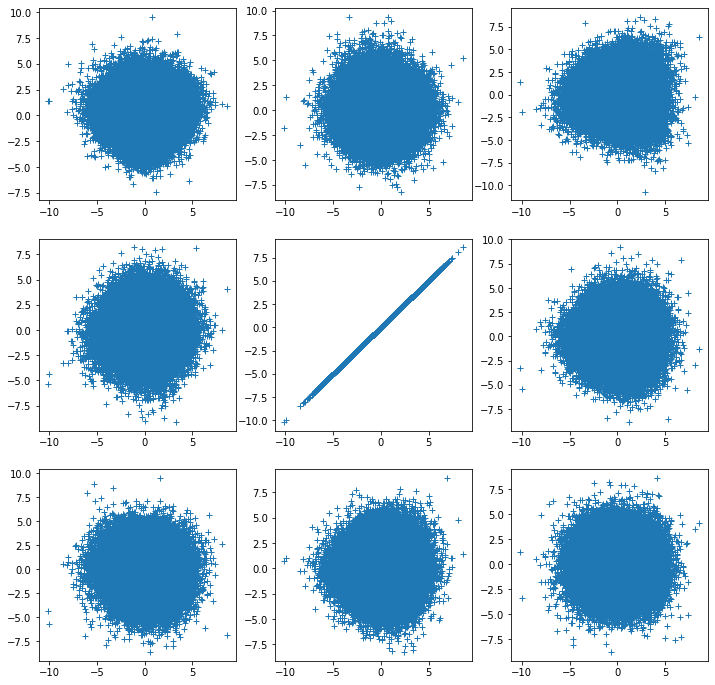

In [145]:
_, axes = plt.subplots(3, 3, figsize=(12, 12))
for i in range(0, 9):
    axes.flat[i].plot(
        whites["net.module.layer4.0.conv2.weight_prior.p"][:, 4],
        whites["net.module.layer4.0.conv2.weight_prior.p"][:, i],
        marker='+', ls='none'
    )
    

In [63]:
for key, (_, cov) in mean_covs.items():
    if len(cov.shape) != 2:
        continue
    beta, loc, scale = fits_dict[key]["gennorm"]
    base_lik = scipy.stats.gennorm.logpdf(whites[key], beta, loc, scale).sum()
    new_lik = scipy.stats.gennorm.logpdf(whites[key], beta, 0., scale).sum()
    print(key, (new_lik-base_lik)/np.abs(base_lik))

net.module.conv1.weight_prior.p -1.0884383504143316e-07
net.module.layer1.0.conv1.weight_prior.p 2.451569758521996e-06
net.module.layer1.0.conv2.weight_prior.p -5.431710524449498e-09
net.module.layer1.1.conv1.weight_prior.p 5.4379952030517306e-08
net.module.layer1.1.conv2.weight_prior.p 5.2071463384289035e-11
net.module.layer2.0.conv1.weight_prior.p -7.013343841039127e-10
net.module.layer2.0.conv2.weight_prior.p -1.8474175137214229e-10
net.module.layer2.1.conv1.weight_prior.p 1.5933000433899277e-06
net.module.layer2.1.conv2.weight_prior.p -5.375978545097378e-06
net.module.layer3.0.conv1.weight_prior.p 1.6501908566580962e-10
net.module.layer3.0.conv2.weight_prior.p -0.0027019501906539755
net.module.layer3.1.conv1.weight_prior.p -3.8427107607356965e-07
net.module.layer3.1.conv2.weight_prior.p -2.604125230555e-08
net.module.layer4.0.conv1.weight_prior.p 3.312226750466549e-10
net.module.layer4.0.conv2.weight_prior.p 1.1363779402170082e-09
net.module.layer4.1.conv1.weight_prior.p 5.39630858

In [61]:
beta, _, scale = fits_dict["net.module.layer1.0.conv1.weight_prior.p"]["gennorm"]

In [136]:
for k, v in fits_dict.items():
    print(k, v["gennorm"][0])

net.module.conv1.weight_prior.p 0.37141051199595776
net.module.layer1.0.conv1.weight_prior.p 0.25312188021897375
net.module.layer1.0.conv2.weight_prior.p 0.5984252087819824
net.module.layer1.1.conv1.weight_prior.p 0.5525029979708702
net.module.layer1.1.conv2.weight_prior.p 0.7893835520462456
net.module.layer2.0.conv1.weight_prior.p 1.1626429570821757
net.module.layer2.0.conv2.weight_prior.p 0.9674905271968595
net.module.layer2.1.conv1.weight_prior.p 0.24961037135584013
net.module.layer2.1.conv2.weight_prior.p 0.22482890809145656
net.module.layer3.0.conv1.weight_prior.p 1.349511465741597
net.module.layer3.0.conv2.weight_prior.p 0.41042831100440097
net.module.layer3.1.conv1.weight_prior.p 0.33221343503441847
net.module.layer3.1.conv2.weight_prior.p 0.8816315883667578
net.module.layer4.0.conv1.weight_prior.p 1.3605804843104834
net.module.layer4.0.conv2.weight_prior.p 1.3561669024680771
net.module.layer4.1.conv1.weight_prior.p 1.031530340187151
net.module.layer4.1.conv2.weight_prior.p 1.05

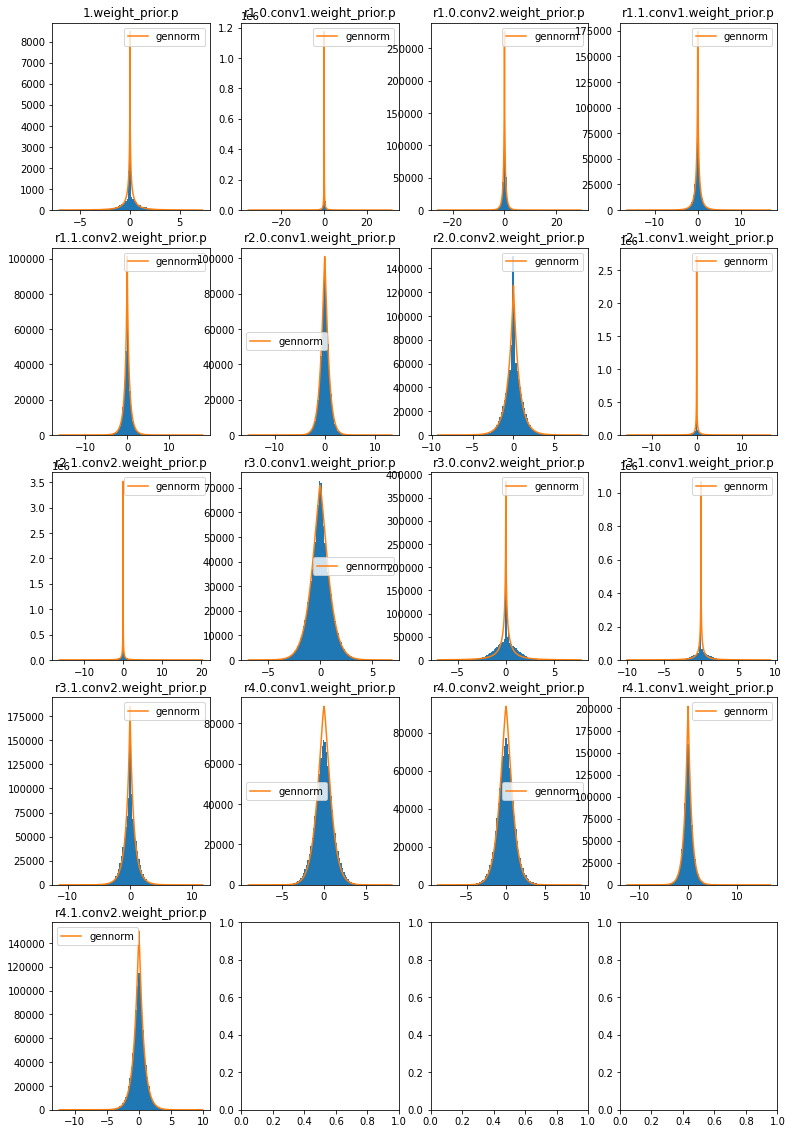

In [43]:
fig, axes = plt.subplots(5, 4, figsize=(13, 20))

i = 0
for key, (_, cov) in mean_covs.items():
    if len(cov.shape) != 2:
        continue
    ax = axes.flat[i]
    i += 1
    
    plot_top_fits(whites[key].ravel()[:1000000], [("gennorm", None, fits_dict[key]["gennorm"])],
                  key[15:], slice(0, 1), ax=ax, bins=100)

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1722: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))
/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


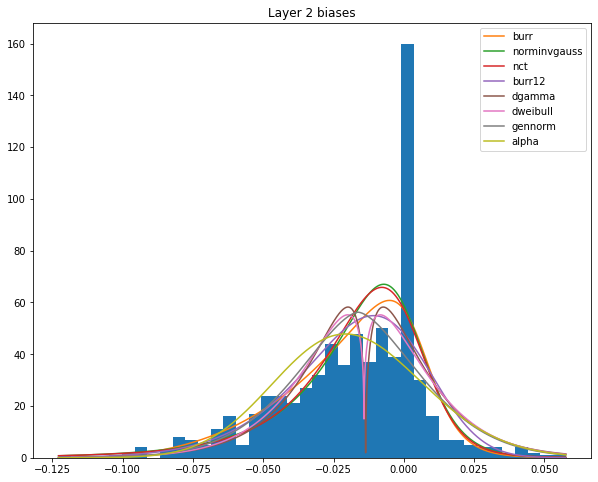

In [159]:
key = "net.module.4.bias_prior.p"
fits[key], fits_dict[key] = fit_1d_dist(samples[key], whitelist=["norminvgauss", "burr", "alpha", "gennorm", "nct", "burr12", "dgamma", "dweibull"])
plot_top_fits(samples[key], fits[key], "Layer 2 biases", slice(0, 10))

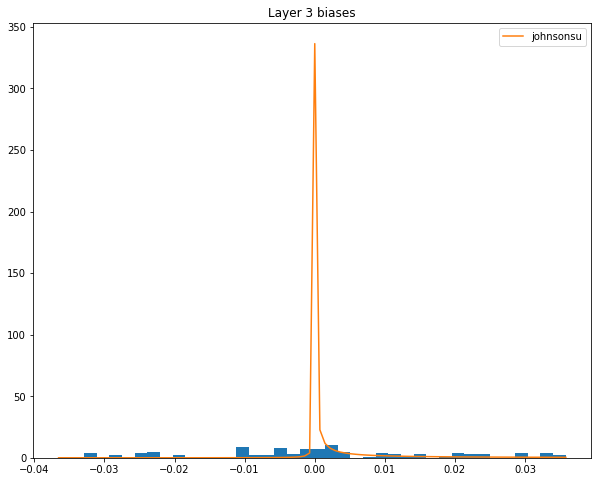

In [88]:
key = "net.module.8.bias_prior.p"
fits[key], fits_dict[key] = fit_1d_dist(samples[key], whitelist=["uniform"])
plot_top_fits(samples[key], new_fits, "Layer 3 biases", slice(0, 10))

# Fit whitened weights

In [434]:
(0.6218022739172522*(1+0.6218022739172522))**-.5

0.9958063573562664

In [423]:
fits["net.module.4.weight_prior.p"][:4]

[('dgamma',
  -411235.35895490064,
  (0.6218022739172522, -9.415813576589557e-05, 0.8905134407283606)),
 ('dweibull',
  -416990.39845794276,
  (0.6978724093339255, -9.41577247458044e-05, 0.4391861208054413)),
 ('gennorm',
  -445280.9292369319,
  (0.49535950207570445, 2.0218707932287335e-07, 0.09785373134253603)),
 ('johnsonsu',
  -460525.3714947509,
  (0.03137829098239347,
   0.5577666335024614,
   0.02402598746615153,
   0.1651803196364553))]

In [420]:
whites["net.module.1.weight_prior.p"].mean()

-9.960201092739757e-08

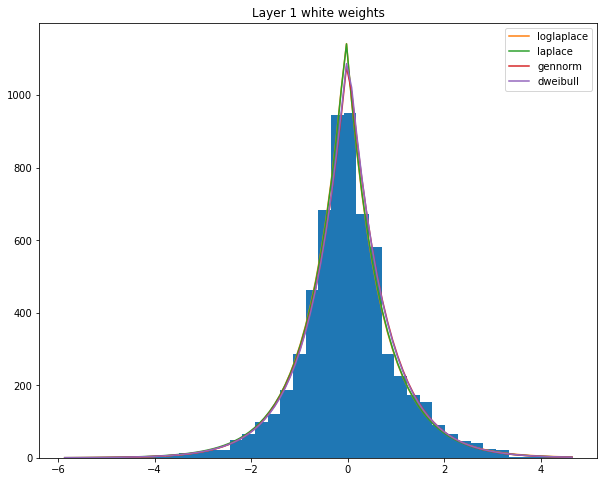

In [446]:
key = "net.module.1.weight_prior.p"
#fits[key], fits_dict[key] = fit_1d_dist(whites[key])
plot_top_fits(whites[key], fits[key], "Layer 1 white weights", slice(2, 6))

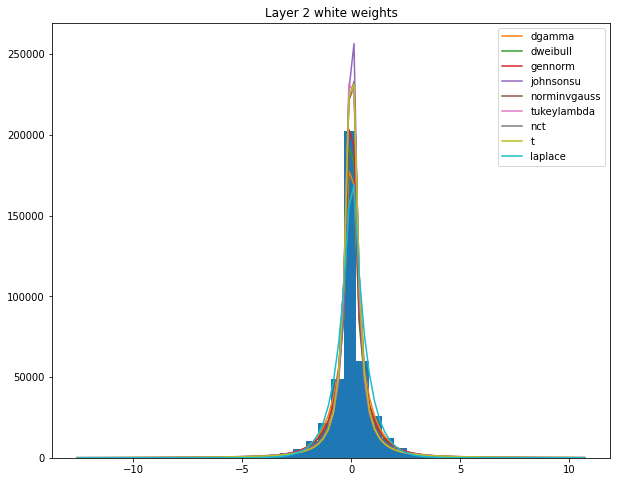

In [447]:
key = "net.module.4.weight_prior.p"
#fits[key], fits_dict[key] = fit_1d_dist(whites[key], whitelist=["dgamma", "dweibull", "gennorm", "johnsonsu", "norminvgauss", "tukeylambda", "nct", "t", "laplace"])
plot_top_fits(whites[key], fits[key], "Layer 2 white weights", slice(0, 10))

In [388]:
import math
math.sqrt(1/ (0.5818346034143134 * (1+ 0.5818346034143134)))

1.0423646891514484

In [380]:
fits["net.module.8.weight_prior.p"][0]

('dgamma',
 -369977.22553797654,
 (0.5818346034143134, -8.769581313337755e-05, 1.0447647225735466))

In [441]:
fits["net.module.8.weight_prior.p"][0]

('dgamma',
 -51106.51511348792,
 (0.279624308582361, -1.3352112244986884e-09, 2.0543955564824206))

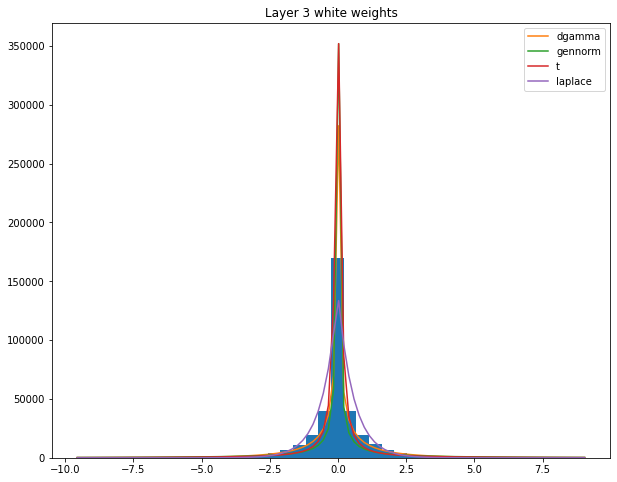

In [448]:
key = "net.module.8.weight_prior.p"
this_whites = (samples[key] - mean_covs[key][0]) * mean_covs[key][1]**-.5

#fits[key], fits_dict[key] = fit_1d_dist(this_whites, whitelist=["dgamma", "laplace", "t", "gennorm"])
plot_top_fits(this_whites, fits[key], "Layer 3 white weights", slice(0, 5))

In [463]:
fits_dict["net.module.8.weight_prior.p"]["dgamma"]

(0.279624308582361, -1.3352112244986884e-09, 2.0543955564824206)

In [445]:
pd.to_pickle((fits, fits_dict), "../bnn_priors/models/fits.pkl.gz")

# Fit the kernel matrix to the covariances

In [75]:
class ConvFitter(torch.nn.Module):
    def __init__(self, kern, weights):
        super().__init__()
        self.register_buffer("inputs", torch.from_numpy(np.mgrid[:3, :3].reshape(2, -1).T.astype(np.float32)))
        self.kern = kern
        #self.raw_std = torch.nn.Parameter(torch.randn(9))
        #self.raw_std_constraint = gpytorch.constraints.Positive()
        
        self.register_buffer("weights", torch.from_numpy(weights).to(self.inputs, copy=True))
        
        cov = self.weights.t() @ self.weights / len(self.weights)
        std = cov.diag()**.5
        self.weights /= std
        
        self.register_buffer("std", std)
        self.register_buffer("cov", cov)
                        
    def forward(self):
        #std = self.raw_std_constraint.transform(self.raw_std)
        #std = self.std
        #L = std.unsqueeze(-1) * self.kern(self.inputs).cholesky().evaluate()
        dist = gpytorch.distributions.MultivariateNormal(
            torch.zeros(len(self.inputs), device=self.inputs.device, dtype=self.inputs.dtype),
            self.kern(self.inputs))
        return dist
    
    def closure(self):
        self.zero_grad()
        dist = self()
        loss = -dist.log_prob(self.weights).sum(0)
        loss.backward()
        return loss

In [76]:
samples_reshaped.keys()

dict_keys(['net.module.conv1.weight_prior.p', 'net.module.layer1.0.conv1.weight_prior.p', 'net.module.layer1.0.conv2.weight_prior.p', 'net.module.layer1.1.conv1.weight_prior.p', 'net.module.layer1.1.conv2.weight_prior.p', 'net.module.layer2.0.conv1.weight_prior.p', 'net.module.layer2.0.conv2.weight_prior.p', 'net.module.layer2.0.shortcut.0.weight_prior.p', 'net.module.layer2.1.conv1.weight_prior.p', 'net.module.layer2.1.conv2.weight_prior.p', 'net.module.layer3.0.conv1.weight_prior.p', 'net.module.layer3.0.conv2.weight_prior.p', 'net.module.layer3.0.shortcut.0.weight_prior.p', 'net.module.layer3.1.conv1.weight_prior.p', 'net.module.layer3.1.conv2.weight_prior.p', 'net.module.layer4.0.conv1.weight_prior.p', 'net.module.layer4.0.conv2.weight_prior.p', 'net.module.layer4.0.shortcut.0.weight_prior.p', 'net.module.layer4.1.conv1.weight_prior.p', 'net.module.layer4.1.conv2.weight_prior.p', 'net.module.linear.bias_prior.p', 'net.module.linear.weight_prior.p'])

In [ ]:
opt_states = {}
for key, (_, cov) in mean_covs.items():
    if len(cov.shape) != 2:
        continue
    
    max_lik = -np.inf
    for name, kern in [#("matern_12",gpytorch.kernels.MaternKernel(nu=1/2)),
                       #("matern_32",gpytorch.kernels.MaternKernel(nu=3/2)),
                       #("matern_52",gpytorch.kernels.MaternKernel(nu=5/2)),
                       ("rbf", gpytorch.kernels.RBFKernel())]:
        
        for _ in range(5):
            cf = ConvFitter(kern, samples_reshaped[key])
            cf.to('cuda')
            optim = torch.optim.LBFGS(cf.parameters())
            cf.kern.lengthscale = torch.rand(()).item() * 3 + 0.01
            try:
                for _ in range(7):
                    loss = optim.step(cf.closure)
            except RuntimeError as e:
                print(e)
            ls = cf.kern.lengthscale.item()
            lik = -loss.item()

            if lik > max_lik:
                max_ls = ls
                max_lik = lik
                max_name = name
                #max_sd = cf.state_dict()
                #del max_sd["weights"]
    opt_states[key] = max_ls
    print(f"For {key}, {max_name} with ls={max_ls}")
opt_states

For net.module.conv1.weight_prior.p, rbf with ls=0.7074809670448303
For net.module.layer1.0.conv1.weight_prior.p, rbf with ls=0.6600028872489929
For net.module.layer1.0.conv2.weight_prior.p, rbf with ls=0.6698659658432007
For net.module.layer1.1.conv1.weight_prior.p, rbf with ls=0.6113624572753906
For net.module.layer1.1.conv2.weight_prior.p, rbf with ls=0.5429970622062683
For net.module.layer2.0.conv1.weight_prior.p, rbf with ls=0.7896473407745361
For net.module.layer2.0.conv2.weight_prior.p, rbf with ls=0.6508743166923523
For net.module.layer2.1.conv1.weight_prior.p, rbf with ls=0.6796390414237976
For net.module.layer2.1.conv2.weight_prior.p, rbf with ls=0.6788411140441895
For net.module.layer3.0.conv1.weight_prior.p, rbf with ls=0.6016831994056702
For net.module.layer3.0.conv2.weight_prior.p, rbf with ls=0.5098036527633667
For net.module.layer3.1.conv1.weight_prior.p, rbf with ls=0.593036949634552
For net.module.layer3.1.conv2.weight_prior.p, rbf with ls=0.6053926944732666
For net.m

In [105]:
opt_states_2

{'net.module.conv1.weight_prior.p': 0.7074809074401855,
 'net.module.layer1.0.conv1.weight_prior.p': 0.6600028872489929,
 'net.module.layer1.0.conv2.weight_prior.p': 0.6698659062385559,
 'net.module.layer1.1.conv1.weight_prior.p': 0.6113624572753906,
 'net.module.layer1.1.conv2.weight_prior.p': 0.5429970622062683,
 'net.module.layer2.0.conv1.weight_prior.p': 0.7896472811698914,
 'net.module.layer2.0.conv2.weight_prior.p': 0.6508743166923523,
 'net.module.layer2.1.conv1.weight_prior.p': 0.6796390414237976,
 'net.module.layer2.1.conv2.weight_prior.p': 0.6788409352302551,
 'net.module.layer3.0.conv1.weight_prior.p': 0.6016831398010254,
 'net.module.layer3.0.conv2.weight_prior.p': 0.5098036527633667,
 'net.module.layer3.1.conv1.weight_prior.p': 0.5930368900299072,
 'net.module.layer3.1.conv2.weight_prior.p': 0.6053927540779114,
 'net.module.layer4.0.conv1.weight_prior.p': 0.5012081265449524,
 'net.module.layer4.0.conv2.weight_prior.p': 0.5246777534484863,
 'net.module.layer4.1.conv1.weight

In [102]:
opt_states_2 = opt_states

In [86]:
sd_base = cf.state_dict()

lengthscales = {}
for k, (_, sd) in opt_states.items():
    sd_base.update(sd)
    cf.load_state_dict(sd_base)
    lengthscales[k]  = cf.kern.lengthscale.item()
lengthscales

{'net.module.conv1.weight_prior.p': 0.7074810266494751,
 'net.module.layer1.0.conv1.weight_prior.p': 0.6600028872489929,
 'net.module.layer1.0.conv2.weight_prior.p': 0.5117807984352112,
 'net.module.layer1.1.conv1.weight_prior.p': 0.6113624572753906,
 'net.module.layer1.1.conv2.weight_prior.p': 0.5429970622062683,
 'net.module.layer2.0.conv1.weight_prior.p': 0.7896473407745361,
 'net.module.layer2.0.conv2.weight_prior.p': 0.6508743166923523,
 'net.module.layer2.1.conv1.weight_prior.p': 0.6796390414237976,
 'net.module.layer2.1.conv2.weight_prior.p': 0.08945411443710327,
 'net.module.layer3.0.conv1.weight_prior.p': 0.6016831398010254,
 'net.module.layer3.0.conv2.weight_prior.p': 0.5098036527633667,
 'net.module.layer3.1.conv1.weight_prior.p': 0.593036949634552,
 'net.module.layer3.1.conv2.weight_prior.p': 0.6053927540779114,
 'net.module.layer4.0.conv1.weight_prior.p': 0.5012080669403076,
 'net.module.layer4.0.conv2.weight_prior.p': 0.5246777534484863,
 'net.module.layer4.1.conv1.weight

In [91]:
lengthscales['net.module.layer4.1.conv2.weight_prior.p'] = 12795201.0

In [93]:
pd.to_pickle(lengthscales, "cifar10_lengthscales.pkl.gz")

In [87]:
opt_states['net.module.layer4.1.conv2.weight_prior.p']

('rbf',
 OrderedDict([('inputs', tensor([[0., 0.],
                       [0., 1.],
                       [0., 2.],
                       [1., 0.],
                       [1., 1.],
                       [1., 2.],
                       [2., 0.],
                       [2., 1.],
                       [2., 2.]], device='cuda:0')),
              ('std',
               tensor([0.0009, 0.0010, 0.0011, 0.0010, 0.0011, 0.0013, 0.0012, 0.0013, 0.0015],
                      device='cuda:0')),
              ('cov',
               tensor([[8.8282e-07, 7.7808e-07, 7.6289e-07, 7.0322e-07, 5.7094e-07, 6.7358e-07,
                        6.9451e-07, 6.6584e-07, 7.2544e-07],
                       [7.7808e-07, 1.0473e-06, 1.0294e-06, 6.9015e-07, 8.6549e-07, 9.5756e-07,
                        6.7909e-07, 8.7369e-07, 9.5139e-07],
                       [7.6289e-07, 1.0294e-06, 1.3068e-06, 6.9046e-07, 8.6499e-07, 1.2013e-06,
                        7.8087e-07, 1.0026e-06, 1.2266e-06],
             

In [83]:
pd.to_pickle(opt_states, "opt_states_rbf.pkl.gz")